In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Lets take a look at station table columns
station_table_columns = session.query(station).first()
station_table_columns.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f01a69ba10>,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'elevation': 3.0}

In [10]:
# Lets take a look at measurement table columns
measurement_table_columns = session.query(measurement).first()
measurement_table_columns.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f01a69b710>,
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 65.0}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
recent_date

'2017-08-23'

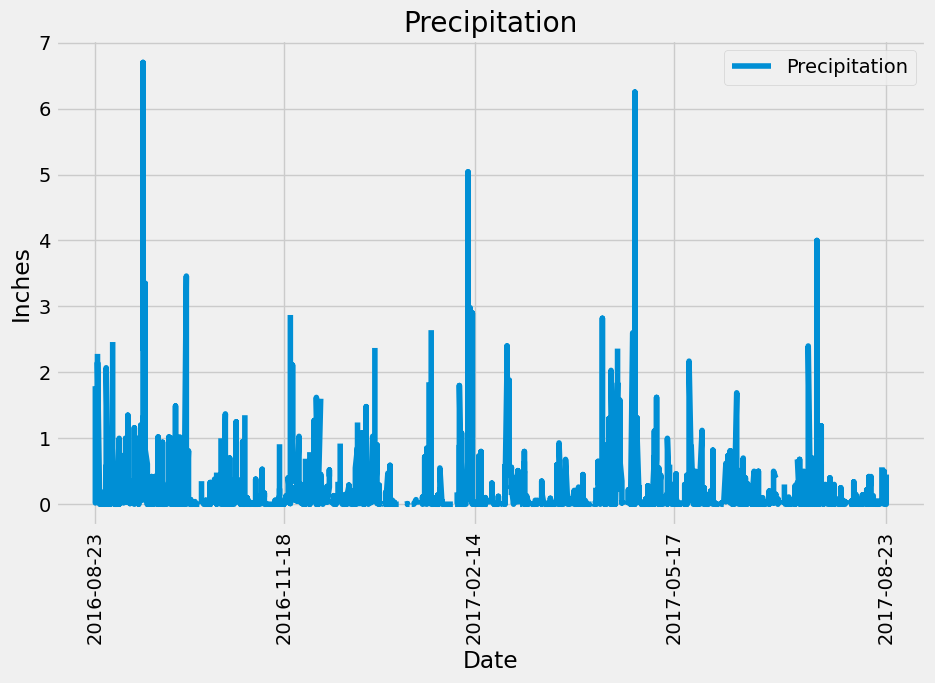

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.fromisoformat(str(recent_date))
last_year = recent_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
data_query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_year).all()

dates = [x[0] for x in data_query]
precipitation_data = [x[1] for x in data_query]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame({'Date':dates, 'Precipitation':precipitation_data})
df.dropna()

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6)) 
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
# As we can not see all dates in x axis, we should only visualize few of them (n)
n = 4
step = len(df) // n
plt.xticks(df['Date'][::step])
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation')
plt.legend()
plt.xticks(rotation=90)
# Show plot
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
number_stations = session.query(measurement).group_by(measurement.station).count()
number_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count()).group_by(measurement.station).order_by(func.count().desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0]
station_name = most_active_station[0]
min_temp = session.query(func.min(measurement.tobs)).filter_by(station=station_name).scalar()
max_temp = session.query(func.max(measurement.tobs)).filter_by(station=station_name).scalar()
avg_temp = session.query(func.avg(measurement.tobs)).filter_by(station=station_name).scalar()

print(f'The lowest temperature is {min_temp}')
print(f'The highest temperature is {max_temp}')
print(f'The average temperature is {round(avg_temp,4)}')

The lowest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.6638


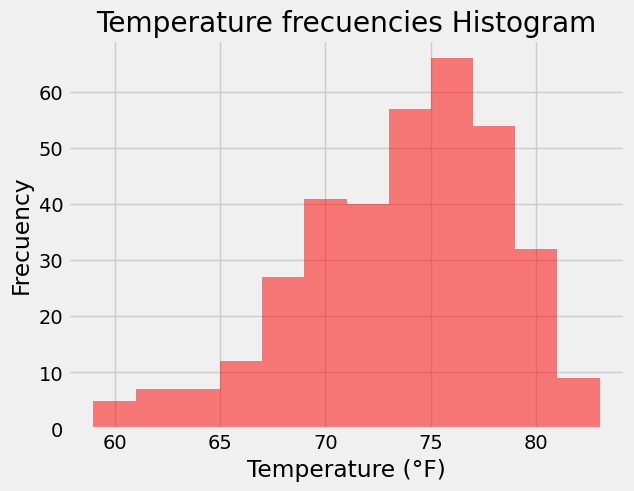

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_station_date = session.query(func.max(measurement.date)).filter_by(station=station_name).scalar()
recent_station_date = dt.datetime.fromisoformat(str(recent_station_date))
last_station_year = recent_station_date - dt.timedelta(days=366)

temperature_query = session.query(measurement.tobs).filter_by(station=station_name).filter(measurement.date >= last_station_year).all()
temperature_data = [x[0] for x in temperature_query]
# Create histogram chart
plt.hist(temperature_data, bins=12, color='red', alpha=0.5)
# Add labels and title
plt.xlabel('Temperature (°F)')
plt.ylabel('Frecuency')
plt.title('Temperature frecuencies Histogram')
# Show plot
plt.show()

# Close Session

In [18]:
# Close Session
session.close()